### Import Libraries

In [24]:
import numpy as np  
import pandas as pd  

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from datetime import datetime

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [25]:
# Parse dates and set date column to index
crypto_df = pd.read_csv("../input/g-research-crypto-forecasting/train.csv") 

In [26]:
crypto_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [27]:
asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


### Preprocessing

In [28]:
df = crypto_df.copy()

In [29]:
# rename column timestamp to Date
df.rename({'timestamp': 'Date'}, axis=1, inplace=True)

In [30]:
# timestamp conversion
df.Date = df.Date.apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))

In [31]:
# Asset_ID = 6 for Ethereum
df = df[df["Asset_ID"]==6].set_index("Date") # Asset_ID = 6 for Ethereum
df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
Index: 1956200 entries, 2018-01-01 to 2021-09-21
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956200 non-null  int64  
 1   Count     1956200 non-null  float64
 2   Open      1956200 non-null  float64
 3   High      1956200 non-null  float64
 4   Low       1956200 non-null  float64
 5   Close     1956200 non-null  float64
 6   Volume    1956200 non-null  float64
 7   VWAP      1956200 non-null  float64
 8   Target    1955860 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 149.2+ MB


In [32]:
df = df.fillna(0)

In [33]:
df.rename(columns={'Close': 'Price'}, inplace=True)

In [34]:
# Convert to date array
timesteps = df.index.to_numpy()
prices = df['Price'].to_numpy()

In [35]:
# How many samples do we have?
len(df)

1956200

In [36]:
# Create train and test splits for time series data
# 80% train, 20% test
split_size = int(0.8 * len(prices)) 

# Create train data splits 
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits 
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1564960, 391240, 1564960, 391240)

### Create a plotting function

In [37]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : start of plot (setting a value will index from start of timesteps & values)
  end :   end of plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("ETH Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(False)

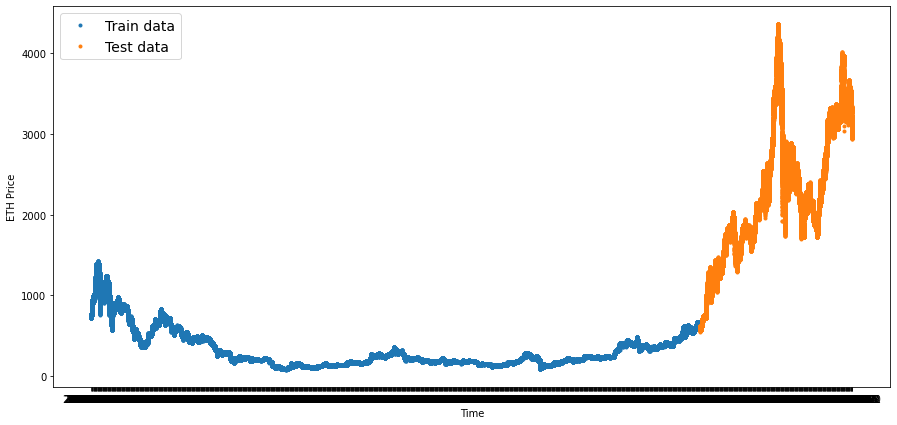

In [38]:
# Create plot
plt.figure(figsize=(15, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

### Modeling: Naive forecast 

In [39]:
### Create a naïve forecast
naive_forecast = y_test[:-1]  
naive_forecast[:10], naive_forecast[-10:] 

(array([611.61142857, 612.32571429, 612.47601221, 611.585     ,
        610.20285714, 610.78875449, 611.16333333, 610.54571429,
        609.97428571, 609.71855792]),
 array([2978.06866385, 2975.14      , 2977.19571429, 2977.38714286,
        2978.13714286, 2974.02714286, 2964.71142857, 2960.84571429,
        2957.39857143, 2977.19      ]))

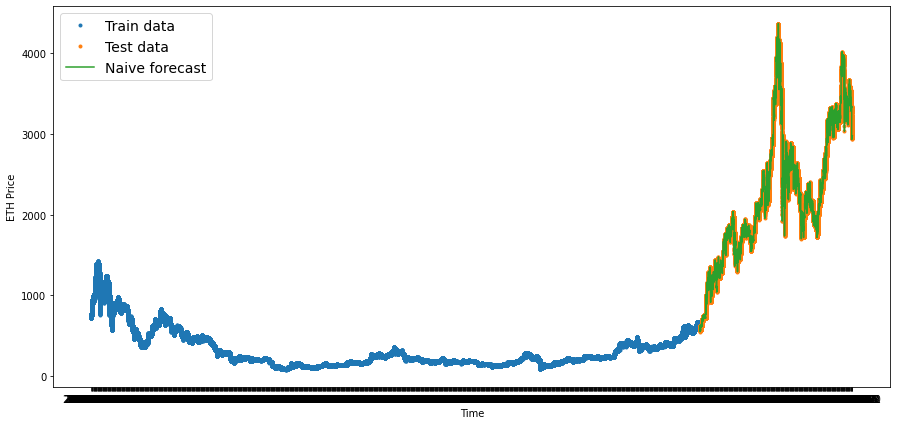

In [40]:
### Plot naive forecast
plt.figure(figsize=(15, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

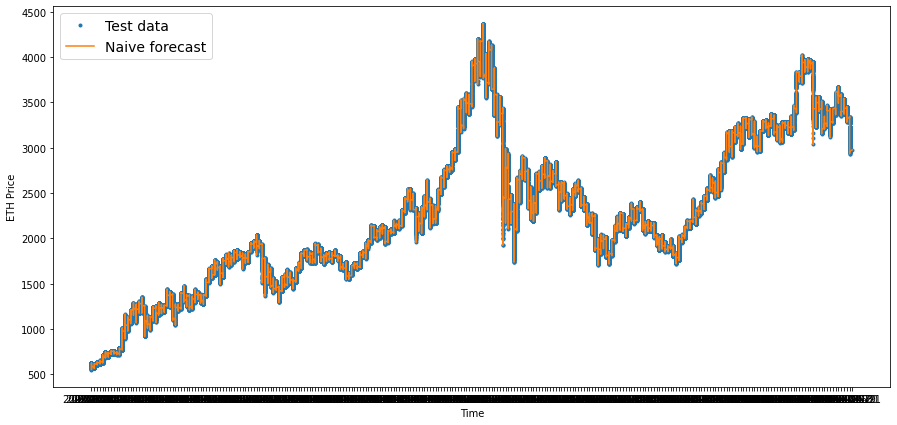

In [41]:
plt.figure(figsize=(15, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

### Evaluating a time series model

In [42]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) 

  return mae / mae_naive_no_season

In [43]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) 
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [44]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 2.3799777,
 'mse': 15.256429,
 'rmse': 3.905948,
 'mape': 0.10965016,
 'mase': 0.9999982}